# Porto Seguro's Safe Driver Prediction

- 데이터: [Porto Seguro's Safe Driver Prediction](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data)
- 필사 참조: [Interactive Porto Insights - A Plot.ly Tutorial](https://www.kaggle.com/code/arthurtok/interactive-porto-insights-a-plot-ly-tutorial/notebook)

### Plotly
: Python에서 시각화 할 수 있는 무료 오픈소스 그래프 라이브러리

**장점** <br/>
- Simple horizontal bar plot: Used to inspect the Target variable distribution
- Correlation Heatmap plot: Inspect the correlation between the diffrent features
- Scatter plot: Compare the feature importances generated by Random Forest adn Gradient-Boosted model
- Vertical bar plot: List in Descending order, the importance of the various features
- 3D Scatter plot

**목차** <br/>
1. Data Quality Checks - Visualizing and evaluating all missing/Null values (values that are -1)
2. Feature inspection and filtering (Correlation and feature Mutual information plots against the target variable. Inspection of the Binary, categorical and other variables)
3. Feature importance ranking via learning models (\n Building a Random Forest and Gradient Boosted model to help us rank features based off the learning process)

In [47]:
# !pip install plotly==4.14.1

In [48]:
# Let us load in the relevant Python modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [49]:
train = pd.read_csv('../data/Porto_Seguro/train.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [50]:
# Taking a look at how many rows and columns the train dataset contains
rows = train.shape[0]
columns = train.shape[1]
print('The train dataset contains {0} rows adn {1} columns'.format(rows, columns))

The train dataset contains 595212 rows adn 59 columns


## 1. Data Quality Checks
### Null or missing values check
> 모든 값이 다 False = isnull()이 하나도 없다 = 결측치가 하나도 없다.

In [51]:
# any() applied twice to check run the isnull check across *all* columns.
train.isnull().any().any()

False

> - null value가 결국 `False`를 리턴하긴 했지만, 'Values of -1 indicate that the feature was missing from the observation' 이다.
> - 따라서 -1 값을 갖는 value들을 null value로 치환하자.

In [52]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

> `Missingno` 패키지의 창시자인 [Aleksey Bilogur](https://www.kaggle.com/residentmario)를 참조해 missing value를 시각화 할 수 있는 유용하고 편안한 툴을 이용해 확인하자.

In [53]:
# !pip install missingno

<AxesSubplot:>

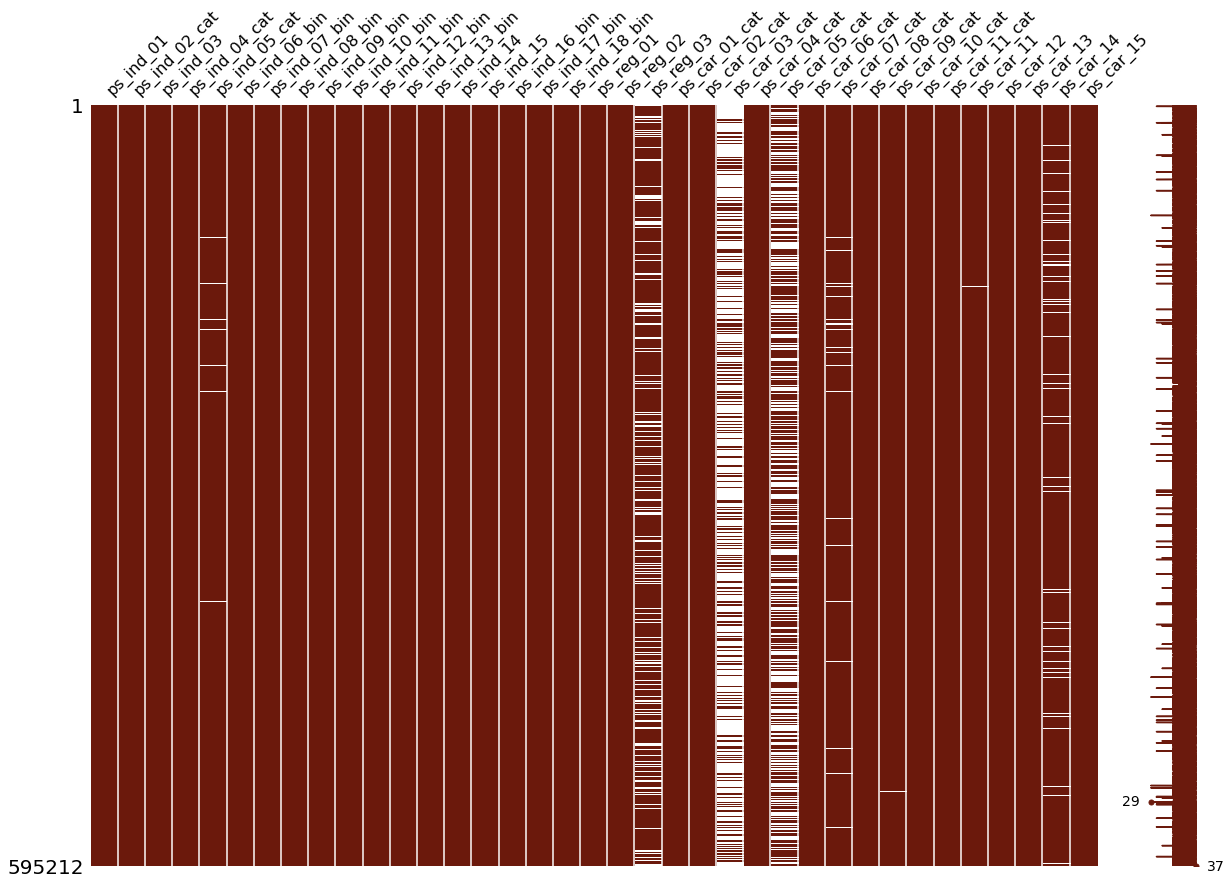

In [54]:
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=train_copy.iloc[:, 2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

> 위에서 볼 수 있듯, missing value들이 더 clear하게 보여진다.
> - 총 59개의 feature(열)이 있었는데 그 중 7개에서 결측치를 발견할 수 있다.
> - 오른쪽 끝엘 보면 feature들이 짤린 것을 볼 수 있는데, 이는 missingno matrix plot이 40개의 odd feature만을 그릴 수 있기 때문이다. 따라서 짤린 나머지 5개 null column을 포함하려면 figsize를 조절해라.

관찰할 수 있는 7개의 null columns는 다음과 같다. <br/>

> **ps_ind_05_cat**, **ps_reg_03**, **ps_car_03_cat**, **ps_car_05_cat**, **ps_car_07_cat**, **ps_car_09_cat**, **ps_car_14** <br/>

대부분의 missing value들은 `_cat`으로 끝나는 변수들에서 많이 나타난다. <br/>

`ps_reg_03`, `ps_car_03_cat`, `ps_car_05_cat`에 대해 생각해보자. 위 missingno matrix plot을 보면 이 3개의 column들에 white band가 진하다, 즉 결측치가 많다. -> `-1`을 null로 대체하는 것은 좋은 방법이 아니구나!

#### Target variable inspection

In [55]:
data = [go.Bar(
            x = train['target'].value_counts().index.values,
            y = train['target'].value_counts().values,
            text='Distribution of target variable'
        )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

<AxesSubplot:xlabel='target', ylabel='count'>

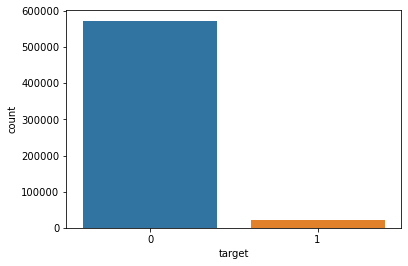

In [79]:
# seaborn으로
sns.countplot(x='target', data=train)

> target value가 굉장히 imbalance하다!

### Datatype check
train 데이터가 어떤 데이터타입을 갖고 있는지 확인해보자.
- integers, characters, floats: just to gain a better overfiew of the data
- 파이썬에서 unique type을 얻을 수 있는 한 가지 trick은 바로 **Collections** 모듈의 `Counter` 메소드이다.

In [56]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

- 우린 총 59개의 column을 가지는데, 보다시피 49개의 `integer`과 10개의 `float`형, 총 2가지의 데이터타입을 가진다.
- 또 한 가지 특징은 해당 데이터가 이미 우리에게 `_bin`, `_cat`, `_reg`로 끝나는 header를 준 점이다.
    - `_bin`: binary
    - `_cat`: categorical
    - `_reg`: continuous or ordinal
> `float` probably only be the continous features, `integer` probably be categorical, ordinal features

In [57]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

### Correlation plots
feature들 간의 상관관계가 있는지 quick look을 하기 위해 linear correlation plot을 생성해보자.
- seaborn의 heatmap을 통해 correlation value 사용하기
- pandas의 corr(): Pearson correlation을 계산함

#### Correlation of float features

<AxesSubplot:title={'center':'Pearson correlation of contious features'}>

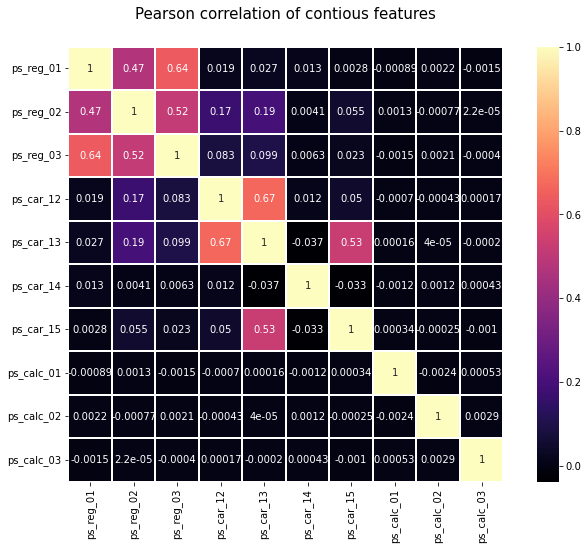

In [58]:
colormap = plt.cm.magma
plt.figure(figsize=(12, 8))
plt.title('Pearson correlation of contious features', y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0, square=True,
            cmap=colormap, linecolor='white', annot=True)

거의 대부분 상관관계가 0이거나 거의 없는데, 아래의 paired features는 어느정도의 양의 상관관계를 보인다.
- **ps_reg_01, ps_reg_03**
- **ps_reg_02, ps_reg_03**
- **ps_car_12, ps_car_13**
- **ps_car_13, ps_car_15**

### Correlation of integer features
integer 데이터타입을 가지는 column에서 correlation의 heatmap을 그리기 위해 Plotly 라이브러리를 사용하겠다. 여기서도 간단히 `go.Heatmap`을 통해 heatmap을 뽑아 내는데, 3가지 다른 축을 새엇ㅇ한다.
- x, y축; 열 이름
- z축: correlation 값

In [59]:
# train_int = train_int.drop(['id', 'target'], axis=1)
# colormap = plt.cm.bone
# plt.figure(figsize=(21, 16))
# plt.title('Pearson correlation of categorical features', y=1.05, size=15)
# sns.heatmap(train_int.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=False)

In [60]:
data = [
    go.Heatmap(
        z=train_int.corr().values,
        x=train_int.columns.values,
        y=train_int.columns.values,
        colorscale='Viridis',
        reversescale=False,
        text=['Correlation'],
        opacity=1.0)
]

layout = go.Layout(
    title='Pearson Correlation of Integer-type features',
    xaxis=dict(ticks='', nticks=36),
    yaxis=dict(ticks=''),
    width=900,
    height=700)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

서로 linearly 상관 관계가 크게 없는 huge column들이 있다. 또 상관관계 plot에 0 value가 굉장히 많다.
- 이는 우리에게 매우 좋은 지표이고, 특히 차원축소(PCA)를 진행하기 위해 좋다.

**Negatively correlated features**: ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin

또 한 가지 특징은 이전 nullity 분석에서 `ps_car_03`과 `ps_car_05`는 많은 missing value를 가졌는데, 따라서 이 feature들이 서로 서로 높은 양의 상관관계를 가지는 것은 놀랍지 않은 결과이다.

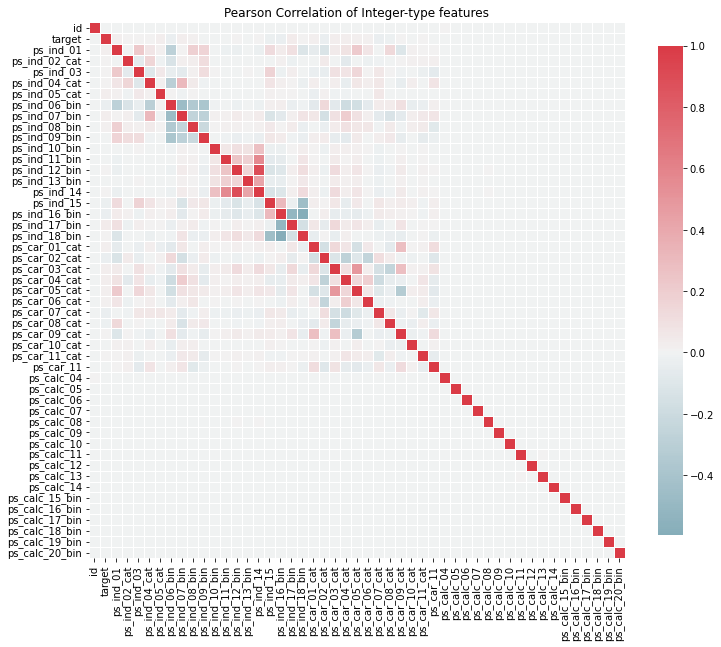

In [71]:
# pandas로 그리기
corrs = train_int.corr()
fig, ax = plt.subplots(figsize=(12, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corrs, cmap=cmap, vmax=1.0, center=0, fmt='.2f', square=True, lineWidths=.5, cbar_kws={'shrink': .75})
plt.title('Pearson Correlation of Integer-type features')
plt.show()